### Kelly criterion and position sizing

reference : Hudson theme - working papers

#### Data import

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

In [2]:
data_train = pd.read_csv('train.csv', index_col = 0, parse_dates = True)
data_test = pd.read_csv('test.csv', index_col = 0, parse_dates = True)

data_train.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,prob,prob_iso,pred_iso
1996-09-16,0.017992,0,0.0,-0.011306,1,0.000000,-0.001710,-0.024446,0.0,0,0.483883,0.359934,0
1996-09-17,-0.011306,0,0.0,-0.023230,0,-0.011306,0.017992,-0.001710,0.0,0,0.000000,0.000000,0
1996-09-18,-0.023230,0,1.0,0.003880,0,-0.000000,-0.011306,0.017992,0.0,0,0.000000,0.000000,0
1996-09-19,0.003880,0,1.0,0.017922,1,0.000000,-0.023230,-0.011306,0.0,1,0.539161,0.506199,1
1996-09-20,0.017922,0,0.0,-0.011900,1,0.017922,0.003880,-0.023230,0.0,0,0.480208,0.351600,0


p model에서 label이 1인 것들만 filtering하여 prob의 histogram을 살펴보자

In [3]:
data = data_train[data_train['pmodel'] == 1]

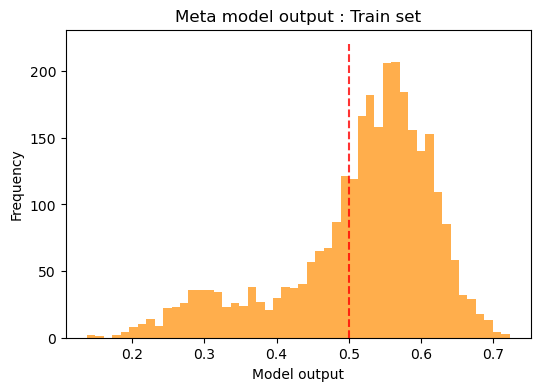

In [8]:
plt.figure(figsize = (6, 4))
plt.hist(data['prob'], color = 'darkorange', alpha = 0.7, bins = 50)
plt.title('Meta model output : Train set')
plt.xlabel('Model output')
plt.ylabel('Frequency')
plt.grid(False)
plt.vlines(x = 0.5, ymin = 0, ymax = 220, colors = 'red', linestyles = '--', alpha = 0.8)
plt.show()

기대되는 win & loss의 값을 구한다

In [10]:
true_pos = data[(data['pred'] == 1) & (data['target'] == 1)]
false_pos = data[(data['pred'] == 1) & (data['target'] == 0)]

exp_gain = true_pos['target_rets'].mean()
exp_loss = false_pos['target_rets'].mean()

print(f'E[gain] : {np.round(exp_gain, 3)}')
print(f'E[loss] : {np.round(exp_loss, 3)}')

E[gain] : 0.014
E[loss] : -0.012


kelly criterion 함수를 정의한다

In [11]:
def kelly(p, win, loss) : return (p / abs(loss)) - ((1 - p) / win)

포지션 사이즈를 계산하여, kelly 기준을 이용한 포저션의 prob을 histogram으로 시각화한다

In [12]:
b = kelly(p = data['prob'], win = exp_gain, loss = exp_loss)

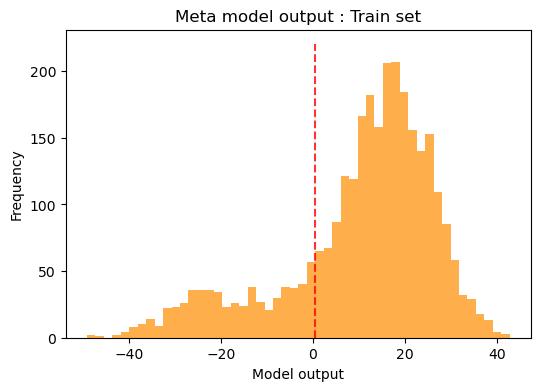

Max level : 42.69


In [14]:
plt.figure(figsize = (6, 4))
plt.hist(b, color = 'darkorange', alpha = 0.7, bins = 50)
plt.title('Meta model output : Train set')
plt.xlabel('Model output')
plt.ylabel('Frequency')
plt.grid(False)
plt.vlines(x = 0.5, ymin = 0, ymax = 220, colors = 'red', linestyles = '--', alpha = 0.8)
plt.show()

print(f'Max level : {np.round(b.max(), 2)}')

In [15]:
kelly(p = 0.468, win = 0.014, loss = 0.012)

1.0

p = 0.468일 때, 모든 포지션 사이즈가 1로 점핑한다. 따라서 prob이 0.5 이상일 때 1의 포지션 크기를 잡는 것은 유용하지 못하다

#### Frequentist analog

빈도주의 확률로 베이시안 확률을 매핑할 수 있는지 알아보자

- manual mapping(수동적 매핑)
- model calibration(확률 보정)
- lit review(문헌 리뷰)

십분위로 분할하여 넣고, 그 분할된 수가 얼마나 자주 발생하는지 확인한다

In [16]:
data['cat'], b, = pd.qcut(data['prob'], q = 10, retbins = True) # 10분위수로 cutting

10분위수당 확률을 계산하여 plotting한다

In [17]:
acc = data.groupby(['cat', 'target']).count()['prob'].unstack()
accuracy = acc[1] / acc.sum(axis = 1)

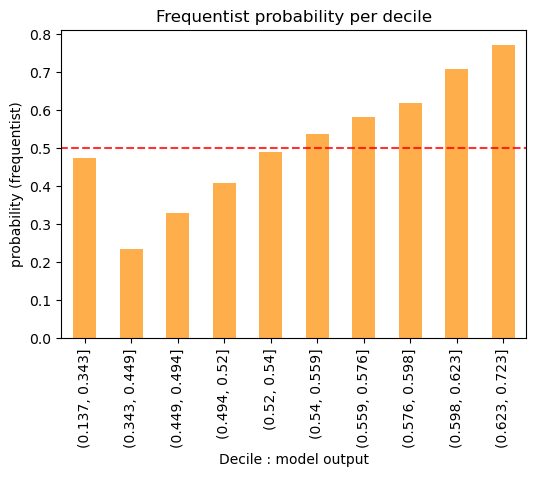

In [20]:
accuracy.plot.bar(figsize = (6, 4), color = 'darkorange', alpha = 0.7)
plt.title('Frequentist probability per decile')
plt.xlabel('Decile : model output')
plt.ylabel('probability (frequentist)')
plt.grid(False)
plt.hlines(y = 0.5, xmin = -1, xmax = accuracy.shape[0], colors = 'red', linestyles = '--', alpha = 0.8)
plt.show()

kelly criterion은 매우 민감하다. p > 0.467이라면 결과값이 1 이상이 된다

In [21]:
kelly(p = 0.467, win = exp_gain, loss = exp_loss)

2.592665016655289

참고: 각 10분위마다 예상되는 win / loss가 있다

In [22]:
exp_wins = data[data['target_rets'] > 0].groupby(['cat'])['target_rets'].mean()
exp_losses = data[data['target_rets'] < 0].groupby(['cat'])['target_rets'].mean()

In [25]:
exp_wins

cat
(0.137, 0.343]    0.013399
(0.343, 0.449]    0.012302
(0.449, 0.494]    0.010421
(0.494, 0.52]     0.010687
(0.52, 0.54]      0.011665
(0.54, 0.559]     0.014559
(0.559, 0.576]    0.012745
(0.576, 0.598]    0.014608
(0.598, 0.623]    0.014433
(0.623, 0.723]    0.017117
Name: target_rets, dtype: float64

In [35]:
pstore, sstore = [], []
for i in range(0, 10):
    indx = i
    b = kelly(accuracy.iloc[indx], exp_wins.iloc[indx], exp_losses.iloc[indx])
    p = np.round(accuracy.iloc[indx], 3)
    print(f'Probability : {p : .3f} \twin : {np.round(exp_wins.iloc[indx], 3) : .3f} \tloss : {np.round(exp_losses.iloc[indx], 3) : .3f}')
    scaled = np.round(np.min([np.max([b, 0]), 1]), 2)
    print(f'Size : {np.round(b, 2)} \tScaled : {scaled}') 
    print('-----------------------------------------------------\n')
    pstore.append(p)
    sstore.append(scaled)

Probability :  0.475 	win :  0.013 	loss : -0.011
Size : 2.49 	Scaled : 1.0
-----------------------------------------------------

Probability :  0.234 	win :  0.012 	loss : -0.018
Size : -49.54 	Scaled : 0.0
-----------------------------------------------------

Probability :  0.329 	win :  0.010 	loss : -0.015
Size : -42.23 	Scaled : 0.0
-----------------------------------------------------

Probability :  0.408 	win :  0.011 	loss : -0.013
Size : -23.77 	Scaled : 0.0
-----------------------------------------------------

Probability :  0.490 	win :  0.012 	loss : -0.013
Size : -5.53 	Scaled : 0.0
-----------------------------------------------------

Probability :  0.538 	win :  0.015 	loss : -0.010
Size : 19.8 	Scaled : 1.0
-----------------------------------------------------

Probability :  0.584 	win :  0.013 	loss : -0.011
Size : 21.5 	Scaled : 1.0
-----------------------------------------------------

Probability :  0.619 	win :  0.015 	loss : -0.011
Size : 27.78 	Scaled : 1.0

각 분위별 포지션 사이즈를 확인해 보자

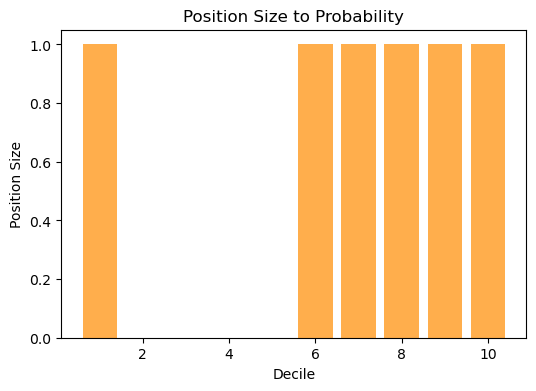

In [38]:
plt.figure(figsize = (6, 4))
plt.bar([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], sstore, color = 'darkorange', alpha = 0.7)
plt.title('Position Size to Probability')
plt.ylabel('Position Size')
plt.xlabel('Decile')
plt.show()

#### Probability Calibration

다음을 참고하자 : 
- https://towardsdatascience.com/calibrating-classifiers-559abc30711a

In [39]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

In [44]:
bins = 10
print(f"Min : {np.round(data['prob'].min(), 2)} \t Max : {np.round(data['prob'].max(), 2)}\n")

Min : 0.14 	 Max : 0.72


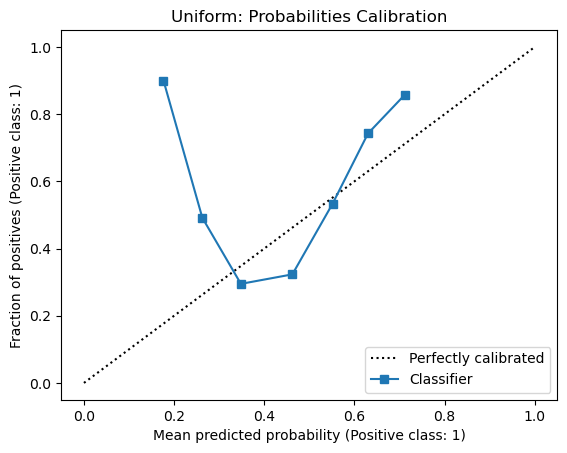

In [54]:
fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(y_true = data['target'], y_prob = data['prob'], n_bins = bins, strategy = 'uniform', ax = ax)
plt.title('Uniform: Probabilities Calibration')
plt.show()

Text(0.5, 1.0, 'Quantile: Probabilities Calibration')

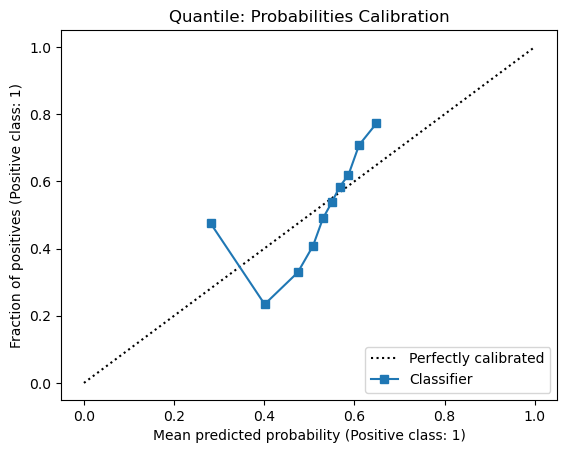

In [55]:
fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(y_true = data['target'], y_prob = data['prob'], n_bins = bins, strategy = 'quantile', ax = ax)
plt.title('Quantile: Probabilities Calibration')

많은 모형이 특히 매우 낮고 높은 값에 대해 편향된 확률 추정치를 추정하는 이유는 무엇일까?

- 작동 방식에 따라 모델마다 이유가 조금씩 다르다
- Naive Bayes, SVM 또는 Decision Tree와 같은 많은 다른 분류 모델도 S자형 calibration curve를 생성할 것이다
- 이에 대한 일반적인 이유는 대부분의 분류 모델이 binary metric에 대해 최적화되고 scoring되기 때문이다